In [51]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import h5py

import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')

import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

hdf5_filename = "assignment1_data-1.hdf5"


# Read files
with h5py.File(hdf5_filename, "r") as f:
    dset = f["mydataset"]
    label = dset[:,-1] # N by 1, where N is the number of samples
    X = dset[:,0:-1] # N by F, where F is the number of features

# print(label.shape)
# print(X.shape)
# print(X[20000:21000,:])
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = preprocessing.scale(X)
# print(X[20000:21000,:])

class SplittedDataset:

    def __init__(self, X, Y, train_frac, val_frac):
        X = torch.Tensor(X)
        Y = torch.Tensor(Y)
        self.X = X
        self.Y = Y
        self.train_frac = train_frac
        self.val_frac = val_frac
        self.test_frac = 1 - train_frac - val_frac
        # train/val/test split
        permutation = torch.randperm(len(X))
        train_size = int(len(X)*train_frac)
        val_size = int(len(X)*val_frac)
        train_indices = permutation[0 : train_size]
        val_indices = permutation[train_size : train_size + val_size]
        test_indices = permutation[train_size + val_size : ]
        self.X_train = X[train_indices]
        self.Y_train = Y[train_indices]
        self.X_val = X[val_indices]
        self.Y_val = Y[val_indices]
        self.X_test = X[test_indices]
        self.Y_test = Y[test_indices]
    
    def __len__(self):
        return len(self.X)
    
    def __str__(self):
        return "splitted dataset with {} samples and {} training ".format(len(self.X),self.train_frac)

# test
dataset = SplittedDataset(X, label, 0.7, 0.1)
print(dataset)
print(len(dataset))
print(dataset.X_train.shape)
print(dataset.Y_train.shape)
print(dataset.X_val.shape)
print(dataset.X_test.shape)

torch.manual_seed(42)    # reproducible


splitted dataset with 99999 samples and 0.7 training 
99999
torch.Size([69999, 6])
torch.Size([69999])
torch.Size([9999, 6])
torch.Size([20001, 6])


training done!
test loss: 257.3220520019531


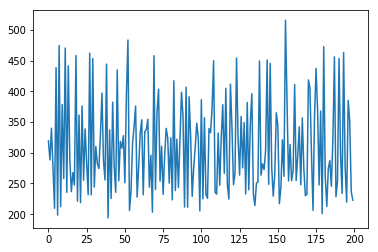

In [58]:
batch_size = 20000
n_epochs = 100

class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden1, n_hidden2, n_output):
        super(Net, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden1)   # hidden layer
        self.bn1 = torch.nn.BatchNorm1d(n_hidden1)
        #self.hidden2 = torch.nn.Linear(n_hidden1, n_hidden2)
        self.predict = torch.nn.Linear(n_hidden1, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden1(x))      # activation function for hidden layer
        x = self.bn1(x)
        #x = F.relu(self.hidden2(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x
    
    def train(self, X, label, n_epochs, batch_size, 
              optimizer = torch.optim.SGD(net.parameters(), lr=0.001),
              loss_func = torch.nn.MSELoss(),
              verbose=False):
        def vprint(s):
            if verbose: 
                print(s)
                
        losses = []
        # train the network
        for t in range(n_epochs):
            vprint("epoch {}".format(t))
            permutation = torch.randperm(len(X))
    
            for batch_index in range(0,len(X),batch_size):
                indices = permutation[batch_index: batch_index + batch_size]

                batch_X, batch_label = X[indices], label[indices]

                prediction = self.forward(batch_X)     # input x and predict based on x
                loss = loss_func(prediction.squeeze(), batch_label)     # must be (1. nn output, 2. target)
                losses.append(loss)
                
                vprint(batch_label[:10])
                vprint("===============")
                vprint(prediction[:10])
                vprint("current loss: {:10.2f}".format(loss))
                vprint("***********************")

                optimizer.zero_grad()   # clear gradients for next train
                loss.backward()         # backpropagation, compute gradients
                optimizer.step()        # apply gradients
        print("training done!")
        plt.plot(losses)
    
    def test(self, X, label, loss_func = torch.nn.MSELoss()):
        prediction = self.forward(X)
        loss = loss_func(prediction.squeeze(), label)
        print("test loss: {}".format(loss))
        
        

# set constants for network
net = Net(n_feature=X.shape[1], n_hidden1=10, n_hidden2=6, n_output=1)     # define the network
net.train(dataset.X_train, dataset.Y_train, 50, 20000, verbose=False)
net.test(dataset.X_test, dataset.Y_test)

In [7]:
print(net.hidden1.weight.data)
print(net.predict.weight.data)


tensor([[  -4442904064.0000, -157047504896.0000,             0.1594,
                    -0.1421, -119395270656.0000, -114991407104.0000],
        [           -0.9523,           -34.3239,            -0.2088,
                    -0.0258,           -13.2486,           -39.7611],
        [            0.0882,            -8.8245,            -0.0186,
                    -0.3696,            -3.4479,            -9.9066],
        [           -1.5487,           -62.9507,            -0.1710,
                    -0.0885,           -53.1806,           -11.8847],
        [           -4.3792,          -172.0611,             0.0046,
                    -0.3446,          -101.3140,           -95.6862],
        [           -0.0487,            -0.3878,            -0.0775,
                     0.1600,            -0.3771,             0.1730],
        [           -0.2929,            -0.3306,             0.2706,
                    -0.3890,            -0.2986,            -0.0458],
        [           -0.2495